In [ ]:
# Используем 

import requests # библиотека для работы с HTTP-запросами
import pandas as pd # библиотека для работы с табличными данными
import time # библиотека для оформления запросов к серверу
from rdkit import Chem # для работы с хим структурами
from rdkit.Chem import Descriptors # вычисляем мол вес


1. Загрузить данные

Получите данные из предоставленной ссылки и загрузите их в удобный формат.

In [98]:
url = 'https://www.ebi.ac.uk/chembl/api/data/activity.json' # сайт сожержит биологическую активность соединений
target = 'CHEMBL230' # мишень
max_size = 1000  # максимум, разрешённый ChEMBL API
out_file = 'cox2_ic50.csv' 

def get(offset):
    params = {
        'target_chembl_id': target,
        'standard_type': 'IC50', # выбираем тип ативности 'IC50' как наиболее представленный в датасете.
        'limit': max_size,
        'offset': offset
    }
    try:
        # Отправляем запрос к API с заданными параметрами
        response = requests.get(url, params=params)
        # Если ошибка - вызывается исключение
        response.raise_for_status()
        # Возвращаем json
        return response.json()
    except requests.exceptions.HTTPError as e:
        print(f"Ошибка запроса при offset = {offset}: {e}")

def ext(json_page):
    records = []
    for record in json_page['activities']:
        records.append(record)  # собираем все активности без изменений
    return records

offset = 0
data = []

page = get(offset)
if page is None:
    print("Ошибка при загрузке первой страницы")
    exit()
total_count = page['page_meta']['total_count']  # общее число записей

while offset < total_count:
    print(f"Загрузка: offset = {offset}")
    page = get(offset)
    batch = ext(page)  # получаем биологические активности
    data.extend(batch)
    offset += max_size  # сдвигаем offset
    time.sleep(0.3)  # пауза между запросами

df = pd.DataFrame(data)  
df.to_csv(out_file, index=False) 
print(f"Скачано {len(df)} записей. Сохранено в {out_file}")


Загрузка: offset = 0
Загрузка: offset = 1000
Загрузка: offset = 2000
Загрузка: offset = 3000
Загрузка: offset = 4000
Загрузка: offset = 5000
Загрузка: offset = 6000
Загрузка: offset = 7000
Скачано 7979 записей. Сохранено в cox2_ic50.csv


2. Отобрать релевантные записи

Оставьте только те колонки, которые отражают биологическую активность молекул или понадобятся для дальнейшей работы. Убедитесь, что данные касаются нужного типа активности и содержат численные значения активности в колонке standard_value.

In [99]:
df = pd.read_csv(r"C:\Users\Redmi\Desktop\Биология\cox2_ic50.csv")
df.columns

Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')

In [100]:
# описание признаков
pd.read_csv(r"C:\Users\Redmi\Downloads\chembl_column_description.csv")

,Столбец,Описание
0,action_type,"Тип действия вещества (редко заполняется, част..."
1,activity_comment,"Комментарий к активности (например, “approxima..."
2,activity_id,Внутренний ID активности в базе ChEMBL
3,activity_properties,Доп. свойства активности (чаще всего пусто)
4,assay_chembl_id,"ID эксперимента (ассэя), в котором измерялась ..."
5,assay_description,Краткое описание биотеста
6,assay_type,"Тип теста (B = binding, F = functional и т.д.)"
7,assay_variant_accession,"Мутации или вариации белка, если есть (чаще null)"
8,assay_variant_mutation,"Конкретные мутации белка, если были"
9,bao_endpoint,Тип измерения по BAO-онтологии


МОТИВАЦИЯ ВЫБОРА ПРИЗНАКОВ

НЕ НУЖНЫ:

Метаданные: document_year, journal, src_id и тд -  не обязательны при дальнейшем анализе.

text_value, value — дублируют standard_value.

upper_value, qudt_units, uo_units — редко используются.

assay_variant_*, bao_* — специфические поля для глубокого анализа типов тестов.

type, units, standard_flag — избыточны.

pchembl_value, ligand_efficiency - можно расчитать


НУЖНЫ:

molecule_chembl_id - ID молекулы.

canonical_smiles - SMILES

standard_value - числовое значение активности

standard_units - единицы измерения 

standard_relation	- знак (=, <, >) 

assay_type в ChEMBL — это категория эксперимента , в котором измеряли активность молекулы


In [101]:
# признаки итогового датасета
columns_to_keep = [
    'molecule_chembl_id', 'canonical_smiles', 'standard_value',
    'standard_units', 'standard_relation', 'assay_type'
]

# проверка парсинга, оставляем только IC50 ++ выбираем нужные признаки
df_filtered = df[df['standard_type'].str.upper() == 'IC50'][columns_to_keep].copy()

# удаляем строки, в которых нет численного значения активности в колонке standard_value
df_filtered = df_filtered.dropna(subset=['standard_value'])


In [102]:
df_filtered['assay_type'].value_counts()

assay_type
B    6879
F      78
A      21
Name: count, dtype: int64

5. Проверить корректность молекул

Убедитесь, что все молекулы в датасете имеют валидный SMILES и могут быть интерпретированы химическим инструментом (RDKit или аналогом). Исключите некорректные записи.

In [103]:
def is_valid_smiles(smiles):
    if not isinstance(smiles, str):
        return False
    
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

# Добавим булев столбец с валидностью SMILES
df_filtered['valid_smiles'] = df_filtered['canonical_smiles'].apply(is_valid_smiles)

# Оставим только валидные записи
df_filtered = df_filtered[df_filtered['valid_smiles']].copy()
df_filtered.drop(columns=['valid_smiles'], inplace=True)
df_filtered



,molecule_chembl_id,canonical_smiles,standard_value,standard_units,standard_relation,assay_type
0,CHEMBL297008,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,60.00,nM,=,B
1,CHEMBL289813,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,3230.00,nM,=,B
2,CHEMBL43736,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,80.00,nM,=,B
3,CHEMBL140167,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,0.12,nM,=,B
4,CHEMBL44194,CCc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,100000.00,nM,>,B
...,...,...,...,...,...,...
7974,CHEMBL5417201,CC(=O)N/C=C/c1ccc2c(c1)O[C@H](c1ccc(O)c(O)c1)[...,6430.00,nM,=,B
7975,CHEMBL118,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...,15.00,nM,=,B
7976,CHEMBL3314087,O=C1Nc2ccccc2/C1=C/c1coc2ccccc2c1=O,20.00,nM,=,B
7977,CHEMBL2017291,COc1cc2c(cc1-c1c(C)noc1C)ncc1[nH]c(=O)n([C@H](...,100000.00,nM,>,B


3. Привести значения активности к единому формату

Обратите внимание, что значения активности могут быть представлены в разных единицах (например, нМ, мкМ и др.). Приведите все значения к одним единицам измерения, чтобы обеспечить согласованность данных.

In [104]:
# единицы измерения
df_filtered['standard_units'].value_counts()


standard_units
nM         6950
ug.mL-1      25
ug            1
%             1
Name: count, dtype: int64

Данные с единицами измерения ug и % удалим из датасета. Переконвертируем ug.mL-1 воспользовавшись формулами:

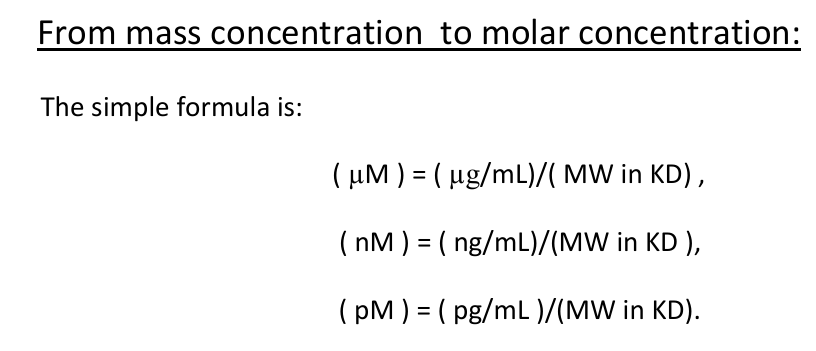

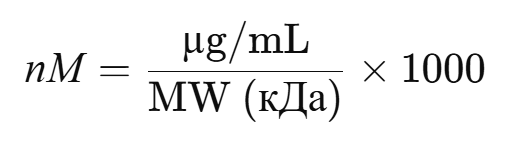

In [ ]:
# Функция для вычисления молекулярного веса
def compute_mw(smiles):
    if not isinstance(smiles, str) or not smiles.strip():
        return None
    mol = Chem.MolFromSmiles(smiles.strip())
    return Descriptors.MolWt(mol) if mol else None


# Добавляем молекулярный вес

df_filtered['molecular_weight'] = df_filtered['canonical_smiles'].apply(compute_mw) / 1000

# Конвертируем
def convert_to_nM(row):
    if row['standard_units'] == 'ug.mL-1' and pd.notna(row['molecular_weight']) and row['molecular_weight'] > 0:
        return (row['standard_value'] / row['molecular_weight']) * 1000
    elif row['standard_units'] == 'nM':
        return row['standard_value']
    return None


df_filtered['standard_value_nM'] = df_filtered.apply(convert_to_nM, axis=1)

valid_rows = df_filtered['standard_value_nM'].notna()
df_filtered = df_filtered.loc[valid_rows].copy()  

df_filtered.loc[:, 'standard_units'] = 'nM'
df_filtered.loc[:, 'standard_value'] = df_filtered['standard_value_nM']

cols_to_drop = ['standard_value_nM', 'molecular_weight', 'standard_units']
df_filtered = df_filtered.drop(columns=[col for col in cols_to_drop if col in df_filtered.columns])


4. Обработать пропущенные значения и дубликаты

Проверьте, есть ли в таблице пропущенные значения или дубликаты. При необходимости — устраните их.

In [ ]:
# Проверка пропущенных значений по столбцам
print('Пропущенные значения в столбцах:')
print(df_filtered.isnull().sum())

# Удаление строк с пропущенными значениями
df_filtered = df_filtered.dropna()

# Проверка дубликатов
print('\nДубликаты по столбцу molecule_chembl_id:')
dup_counts = df_filtered['molecule_chembl_id'].value_counts()
print(dup_counts.head(10))

percent_duplicates = (1 - len(df_filtered['molecule_chembl_id'].unique())/len(df_filtered)) * 100
print(f"\nПроцент дубликатов молекул: {percent_duplicates:.2f}%")



# 1. Первый вариант - простое удаление дубликатов (оставляем первое вхождение)
df_no_duplicates = df_filtered.drop_duplicates(subset=['molecule_chembl_id'], keep='first')

# 2. Второй вариант - агрегирование данных, берем медиану по числовым и моду по категориальным признакам
def aggregate_duplicates(group):
    agg_dict = {
        'canonical_smiles': lambda x: x.iloc[0],
        'standard_value': 'median',
        'standard_relation': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
        'assay_type': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    }
    return group.agg(agg_dict)

df_aggregated = df_filtered.groupby('molecule_chembl_id').apply(aggregate_duplicates).reset_index()


df_no_duplicates.to_csv('no_duplicates_dataset.csv', index=False)
df_aggregated.to_csv('aggregated_dataset.csv', index=False)
df_aggregated

Пропущенные значения в столбцах:
molecule_chembl_id    0
canonical_smiles      0
standard_value        0
standard_relation     0
assay_type            0
dtype: int64

Дубликаты по столбцу molecule_chembl_id:
molecule_chembl_id
CHEMBL118       218
CHEMBL6         121
CHEMBL122        63
CHEMBL521        36
CHEMBL139        26
CHEMBL42485      25
CHEMBL7162       23
CHEMBL25         19
CHEMBL416146     16
CHEMBL56367      16
Name: count, dtype: int64

Процент дубликатов молекул: 26.55%


C:\Users\Redmi\AppData\Local\Temp\ipykernel_6152\4072805366.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_aggregated = df_filtered.groupby('molecule_chembl_id').apply(aggregate_duplicates).reset_index()


,molecule_chembl_id,canonical_smiles,standard_value,standard_relation,assay_type
0,CHEMBL100091,CCCCOCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(...,60.0,=,B
1,CHEMBL100092,CCCCCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(O...,60.0,=,B
2,CHEMBL100156,CS(=O)(=O)c1ccc(-c2cscc2-c2ccccc2)cc1,4000.0,=,B
3,CHEMBL100250,CS(=O)(=O)c1ccc(-c2ccsc2-c2ccccc2)cc1,4000.0,=,B
4,CHEMBL100331,CCCCCCCCNC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc...,40.0,=,B
...,...,...,...,...,...
5118,CHEMBL99374,Cc1ccc(-c2cscc2-c2ccc(S(C)(=O)=O)cc2)cc1,4000.0,=,B
5119,CHEMBL99517,Cc1ccc(-c2sccc2-c2ccc(S(C)(=O)=O)cc2)cc1,13000.0,=,B
5120,CHEMBL99727,CCOC(=O)CCc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(...,130000.0,=,B
5121,CHEMBL99828,Cc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(F)cc2)s1,10000.0,=,B
